In [ ]:
import zipfile

In [ ]:
import os
import random
import zipfile
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation , GlobalAveragePooling2D ,DepthwiseConv2D ,Input ,Add ,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping , LearningRateScheduler
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
!pip install tensorflow-addons==0.17.1
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Try 3

In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Chest_CT_scan_Dataset/fold_1"
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

In [ ]:
class_names = os.listdir(train_dir)
file_paths = []
labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for file_name in os.listdir(class_path):
        file_paths.append(os.path.join(class_path, file_name))
        labels.append(class_name)

# Convert labels to numerical values
label_to_index = {name: index for index, name in enumerate(class_names)}
labels = [label_to_index[label] for label in labels]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(file_paths, labels, test_size=0.2, stratify=labels)


In [ ]:
# Function to create a directory structure for the train and validation sets
def create_data_generator(X, y, dir_name):
    os.makedirs(dir_name, exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for img_path, label in zip(X, y):
        shutil.copy(img_path, os.path.join(dir_name, class_names[label]))

# Create directories for training and validation data
create_data_generator(X_train, y_train, os.path.join(base_path, 'train_split'))
create_data_generator(X_val, y_val, os.path.join(base_path, 'val'))

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train_split'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 734 images belonging to 4 classes.


In [ ]:
validation_generator = val_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 252 images belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 200 images belonging to 4 classes.


In [ ]:
os.makedirs(test_dir, exist_ok=True)


In [ ]:
# Example to list files in the test directory
test_files = os.listdir(test_dir)
print("Number of files in test directory:", len(test_files))

Number of files in test directory: 4


In [ ]:
print("Test directory:", test_dir)


Test directory: /content/drive/MyDrive/Colab Notebooks/Chest_CT_scan_Dataset/fold_1/test


In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [ ]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=4, average="micro", name='f1_score')
]

In [ ]:
# Define the input
input_layer = Input(shape=(224, 224, 3))

# Block 1
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Block 2
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Block 3
block3_output = Conv2D(96, (3,3), activation='relu', padding='same')(x)
block3_output = BatchNormalization()(block3_output)
block3_output = MaxPooling2D((2, 2))(block3_output)

# Block 4
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(block3_output)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
block4_branch = Conv2D(64, (1,1), activation='relu', padding='same')(x)
x = Conv2D(160, (3, 3), activation='relu', padding='same')(block4_branch)
x = BatchNormalization()(x)
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
block4_output = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)

# block3_out = Conv2D(32, (1,1), activation='relu', padding='same')(block3_output)
# block3_out = Conv2D(96, (3, 3), activation='relu', padding='same', dilation_rate=2)(block3_out)
x = Concatenate()([block4_output,  block3_output])
x = MaxPooling2D((2, 2))(x)

# Block 5
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(192, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(96, (1,1), activation='relu', padding='same')(x)
x = Conv2D(224, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)

# MaxPooling before Block 6
main_branch_output = MaxPooling2D((2, 2))(x)
main_branch_output = BatchNormalization()(main_branch_output)

parallel_branch = DepthwiseConv2D(kernel_size=(5,5) ,activation='relu')(block4_branch)
parallel_branch = Conv2D(96, (3,3),padding='same', dilation_rate=2)(parallel_branch)
parallel_branch = BatchNormalization()(parallel_branch)
parallel_branch = ReLU()(parallel_branch)
parallel_branch = MaxPooling2D((2, 2))(parallel_branch)
parallel_branch = DepthwiseConv2D(kernel_size=(5,5) ,activation='relu')(parallel_branch)
# parallel_branch = DepthwiseConv2D(kernel_size=(5,5),activation='relu')(parallel_branch)
parallel_branch = BatchNormalization()(parallel_branch)

main_branch_gap = GlobalAveragePooling2D()(main_branch_output)
parallel_branch_gap = GlobalAveragePooling2D()(parallel_branch)

# Concatenate the GAP outputs
x = Concatenate()([main_branch_gap, parallel_branch_gap])
# x = GlobalAveragePooling2D()(main_branch_output)

# Output layer
output_layer = Dense(4, activation='softmax')(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)         0         ['batch_normalization[0][0

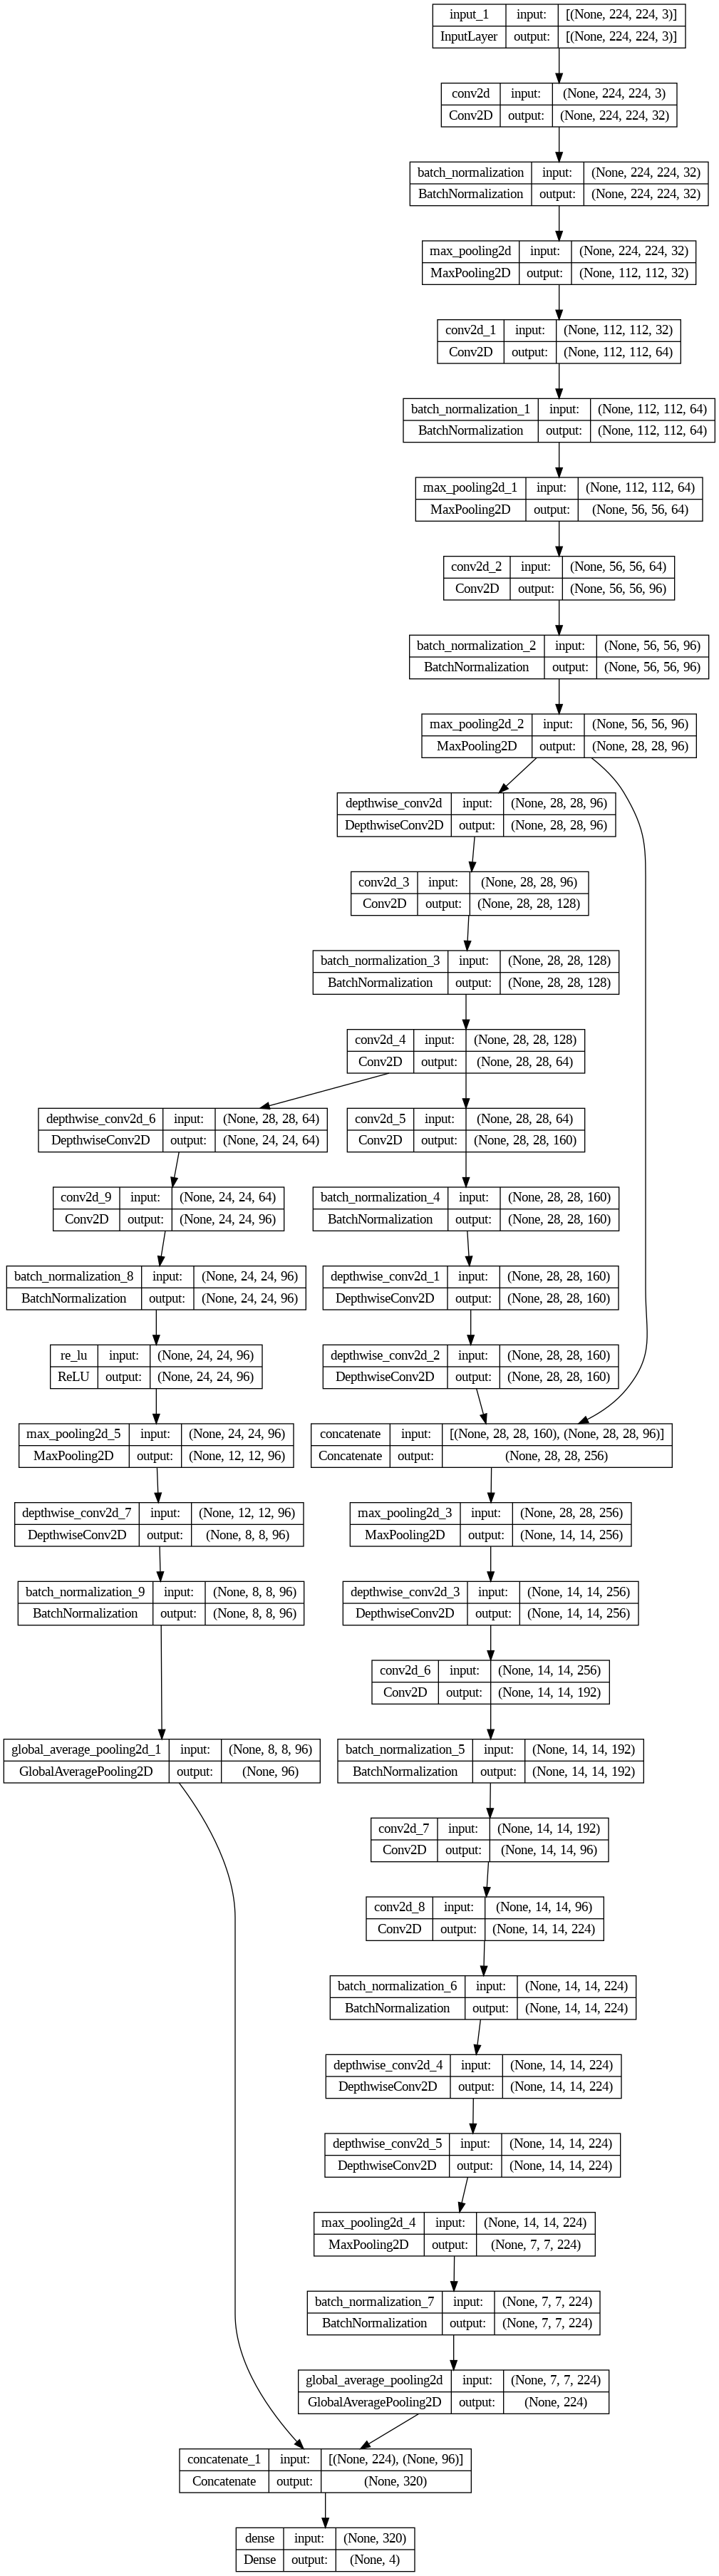

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0005),
    metrics=METRICS
)

In [ ]:
def lr_schedule(epoch,learning_rate):
  if epoch <7:
    return learning_rate
  else:
    return 0.95*learning_rate

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# print("Length of train_dataset:", len(train_dataset))
# print("Length of valid_dataset:", len(valid_dataset))

In [ ]:
callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)#,
    # EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)
]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=[callbacks, lr_scheduler],
        verbose=1
    #  , class_weight=class_weights
)

Epoch 1/35
46/46 [==============================] - ETA: 0s - loss: 0.9854 - accuracy: 0.5436 - precision: 0.7668 - recall: 0.2643 - auc: 0.8227 - f1_score: 0.5436
Epoch 1: val_accuracy improved from -inf to 0.29365, saving model to best_model.keras
46/46 [==============================] - 141s 3s/step - loss: 0.9854 - accuracy: 0.5436 - precision: 0.7668 - recall: 0.2643 - auc: 0.8227 - f1_score: 0.5436 - val_loss: 1.3853 - val_accuracy: 0.2937 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5357 - val_f1_score: 0.2937 - lr: 5.0000e-04
Epoch 2/35
46/46 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.6567 - precision: 0.7918 - recall: 0.4196 - auc: 0.8893 - f1_score: 0.6567
Epoch 2: val_accuracy did not improve from 0.29365
46/46 [==============================] - 6s 125ms/step - loss: 0.8233 - accuracy: 0.6567 - precision: 0.7918 - recall: 0.4196 - auc: 0.8893 - f1_score: 0.6567 - val_loss: 1.4082 - val_accuracy: 0.2937 - val_precision: 0.0000

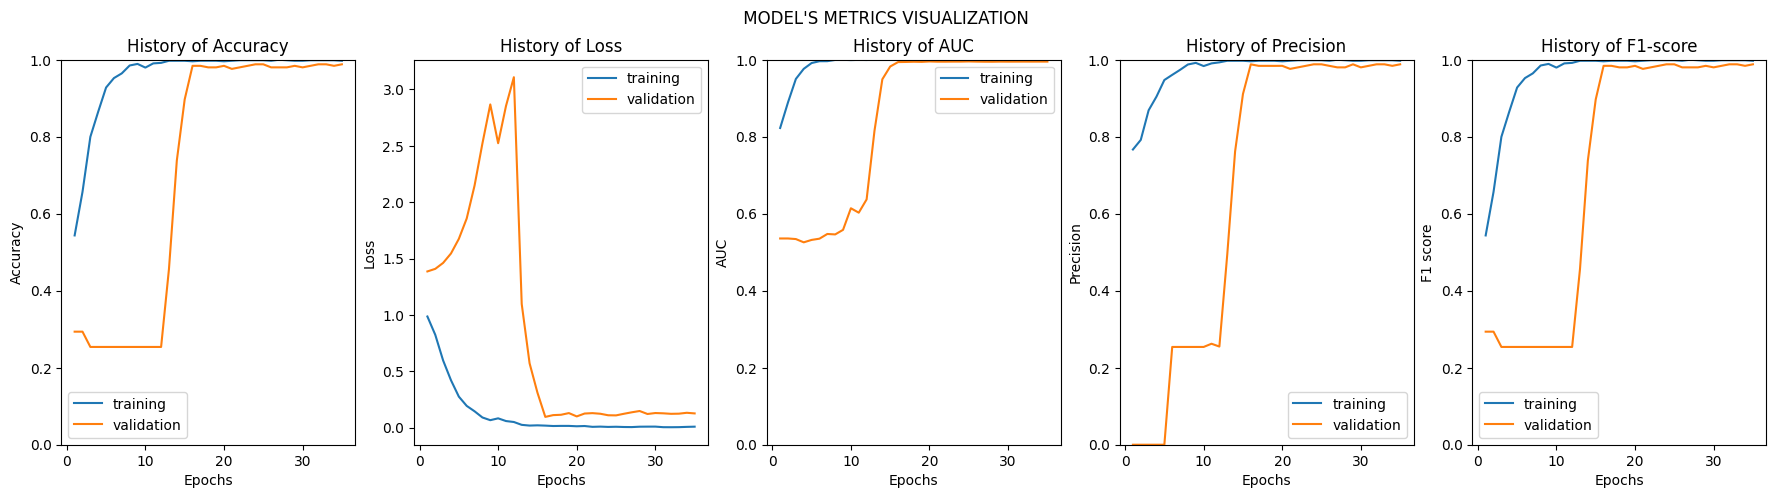

In [ ]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(22, 5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    # Rescale the y-axis for accuracy, auc, precision, and f1
    rescale_factor = 0  # Adjust this factor to control the rescaling

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1.0])
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.set_ylim([rescale_factor, 1.0])
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.set_ylim([rescale_factor, 1.0])
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.set_ylim([rescale_factor, 1.0])
    ax5.legend(['training', 'validation'])

    plt.show()

# Example usage:
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss']
               ,
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])


In [ ]:
model.evaluate(test_generator)

13/13 [==============================] - 68s 6s/step - loss: 0.1104 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9981 - f1_score: 0.9600


[0.11039777100086212,
 0.9599999785423279,
 0.9599999785423279,
 0.9599999785423279,
 0.9980791211128235,
 0.9599999785423279]

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# Load the test dataset
X_test, y_test = [], []
for i in range(len(test_generator)):
    batch_X, batch_y = test_generator[i]
    X_test.append(batch_X)
    y_test.append(batch_y)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Create a classification report
report = classification_report(y_true_classes, y_pred_classes)

print(report)

7/7 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        68
           1       0.95      0.95      0.95        37
           2       0.98      1.00      0.99        43
           3       0.96      0.96      0.96        52

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



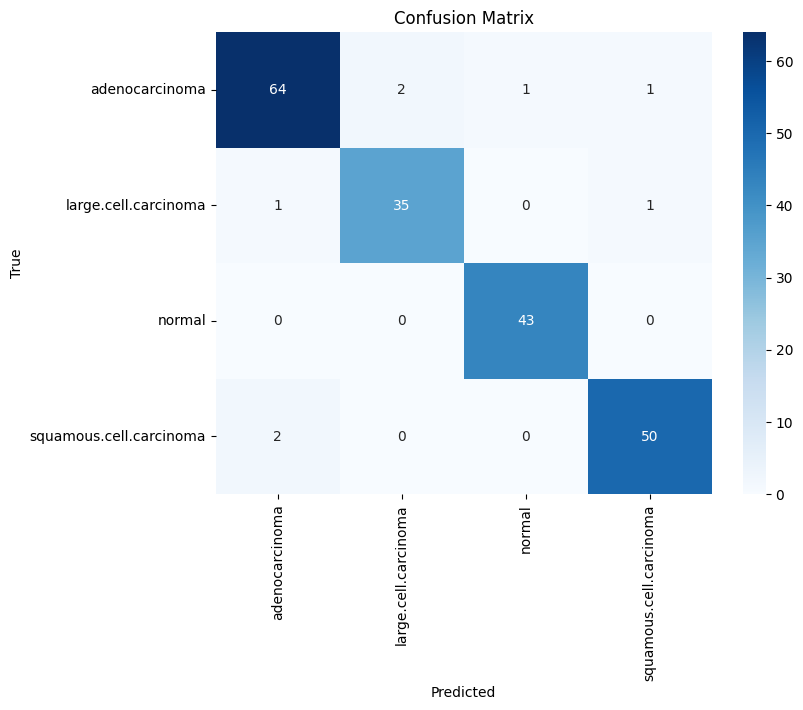

In [ ]:
class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
